#  Курсовая работа по курсу Python для Data Science

https://www.kaggle.com/c/real-estate-price-prediction-moscow/data

* [Загрузка данных](#load)
* [1. EDA](#eda)
* [2. Обработка выбросов](#outlier)
* [3. Обработка пропусков](#nan)
* [4. Построение новых признаков](#feature)
* [5. Отбор признаков](#feature_selection)
* [6. Разбиение на train и test](#split)
* [7. Построение модели](#modeling)
* [8. Прогнозирование на тестовом датасете](#prediction)

Задание: По данным из train.csv, построить модель для предсказания цен на недвижимость (квартиры). 
По полученной модели предсказать цены для квартир из файла test.csv.

Целевая переменная: Price

Основная метрика: R2 - коэффициент детерминации (sklearn.metrics.r2_score)

Дополнительная метрика: MSE - средняя квадратичная ошибка (sklearn.metrics.mean_squared_error)

**Подключение библиотек и скриптов**

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, GridSearchCV
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
matplotlib.rcParams.update({'font.size': 14})

In [5]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

**Пути к директориям и файлам**

In [6]:
TRAIN_DATASET_PATH = 'train.csv'
TEST_DATASET_PATH = 'test.csv'

### Загрузка данных <a class='anchor' id='load'>

**Описание датасета**

* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

In [7]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9995,1260,61,2.0,49.090728,33.272626,6.0,3,12.0,1981,0.300323,B,B,52,10311,6,NaN,1,9,B,119367.455796
9996,16265,27,2.0,64.307684,37.038420,9.0,13,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,199715.148807
9997,2795,178,1.0,29.648057,16.555363,5.0,3,5.0,1958,0.460556,B,B,20,4386,14,NaN,1,5,B,165953.912580
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,B,B,47,8004,3,125.0,3,5,B,171842.411855
9999,7202,94,1.0,35.815476,22.301367,6.0,9,9.0,1975,0.127376,B,B,43,8429,3,NaN,3,9,B,177685.627486


In [8]:
train_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [9]:
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
4995,10379,29,2.0,43.177521,30.339945,5.0,6,5.0,1962,0.069660,B,B,31,6119,4,NaN,1,2,B
4996,16138,38,3.0,93.698122,94.521465,10.0,21,27.0,2018,0.060753,B,B,15,2787,2,520.0,0,7,B
4997,3912,101,1.0,33.656723,19.003259,5.0,2,5.0,1966,0.038693,B,B,28,6533,1,1015.0,2,5,B
4998,5722,10,1.0,38.635155,20.976257,9.0,8,14.0,1970,0.089040,B,B,33,7976,5,NaN,0,11,B
4999,11004,21,2.0,67.122742,33.944344,13.0,9,17.0,2009,0.194489,B,B,47,8004,3,125.0,3,5,B


In [10]:
print('Строк в трейне:', train_df.shape[0])
print('Строк в тесте', test_df.shape[0])

Строк в трейне: 10000
Строк в тесте 5000


In [11]:
train_df.shape[1] - 1 == test_df.shape[1]

True

### Приведение типов

In [12]:
train_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [13]:
train_df['Id'] = train_df['Id'].astype(str)
train_df['DistrictId'] = train_df['DistrictId'].astype(str)

## 1. EDA  <a class='anchor' id='eda'>
- Исправляем  выбросы,
- Заполняем Nan
- Генерация новых фич

**Целевая переменная**

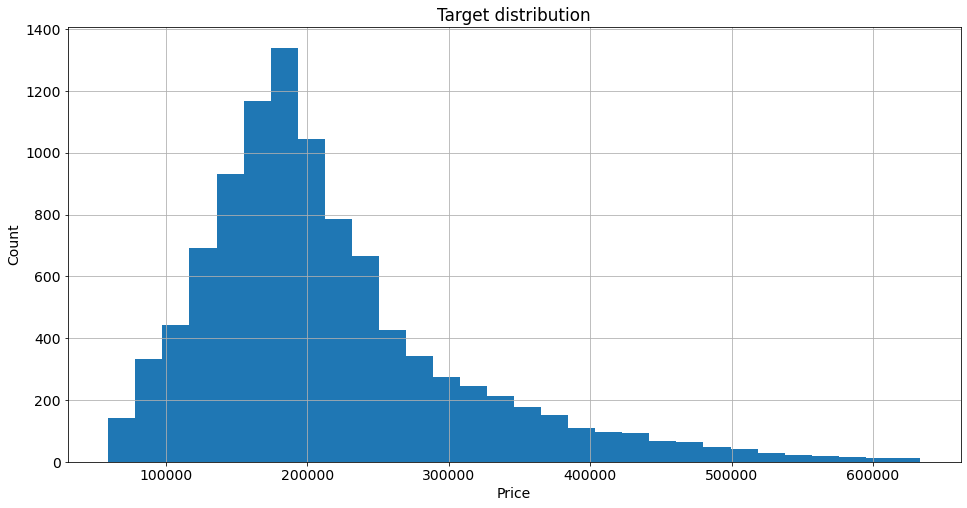

In [14]:
plt.figure(figsize = (16, 8))

train_df['Price'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Price')

plt.title('Target distribution')
plt.show()

**Количественные переменные**

In [15]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


**Номинативные переменные**

In [16]:
train_df.select_dtypes(include='object').columns.tolist()

['Id', 'DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2']

### 2. Обработка выбросов  <a class='anchor' id='outlier'>


**Rooms**

In [17]:
train_df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

In [18]:
train_df['Rooms_outlier'] = 0
train_df.loc[(train_df['Rooms'] == 0) | (train_df['Rooms'] >= 6), 'Rooms_outlier'] = 1
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,...,B,11,3097,0,NaN,0,0,B,305018.871089,0
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,B,30,6207,1,1183.0,1,0,B,177734.553407,0
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,B,33,5261,0,240.0,3,1,B,282078.720850,0
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,...,B,1,264,0,NaN,0,1,B,168106.007630,0
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,B,33,8667,2,NaN,0,6,B,343995.102962,0


In [19]:
train_df.loc[train_df['Rooms'] == 0, 'Rooms'] = 1
train_df.loc[train_df['Rooms'] >= 6, 'Rooms'] = train_df['Rooms'].median()

In [20]:
train_df['Rooms'].value_counts()

2.0    3884
1.0    3713
3.0    2235
4.0     150
5.0      18
Name: Rooms, dtype: int64

**KitchenSquare** 

In [21]:
train_df['KitchenSquare'].value_counts()

1.0       2460
8.0       1306
5.0       1169
10.0      1075
6.0       1038
9.0        843
0.0        697
7.0        609
12.0       249
11.0       233
13.0        67
14.0        51
4.0         39
15.0        31
3.0         22
16.0        16
20.0        14
17.0        12
19.0        11
18.0         6
2.0          4
22.0         3
43.0         2
112.0        2
41.0         2
32.0         2
58.0         2
25.0         2
37.0         2
30.0         2
51.0         2
40.0         1
96.0         1
48.0         1
72.0         1
73.0         1
2014.0       1
66.0         1
36.0         1
78.0         1
54.0         1
29.0         1
31.0         1
35.0         1
62.0         1
39.0         1
1970.0       1
60.0         1
75.0         1
26.0         1
21.0         1
84.0         1
63.0         1
123.0        1
53.0         1
42.0         1
23.0         1
27.0         1
Name: KitchenSquare, dtype: int64

In [22]:
train_df['KitchenSquare'].quantile(.975), train_df['KitchenSquare'].quantile(.025)

(13.0, 0.0)

In [23]:
condition = (train_df['KitchenSquare'].isna()) \
             | (train_df['KitchenSquare'] > train_df['KitchenSquare'].quantile(.975))
        
train_df.loc[condition, 'KitchenSquare'] = train_df['KitchenSquare'].median()

train_df.loc[train_df['KitchenSquare'] < 3, 'KitchenSquare'] = 3

In [24]:
train_df['KitchenSquare'].value_counts()

3.0     3183
8.0     1306
6.0     1227
5.0     1169
10.0    1075
9.0      843
7.0      609
12.0     249
11.0     233
13.0      67
4.0       39
Name: KitchenSquare, dtype: int64

**HouseFloor, Floor**

In [25]:
train_df['HouseFloor'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        36.,  37.,  38.,  39.,  40.,  44.,  45.,  47.,  48.,  99., 117.])

In [26]:
train_df['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42],
      dtype=int64)

In [27]:
(train_df['Floor'] > train_df['HouseFloor']).sum()

1825

In [28]:
train_df['HouseFloor_outlier'] = 0
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
train_df.loc[train_df['Floor'] > train_df['HouseFloor'], 'HouseFloor_outlier'] = 1

In [29]:
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor'] = train_df['HouseFloor'].median()

In [30]:
(train_df['Floor'] > train_df['HouseFloor']).sum()

1610

**HouseYear**

In [31]:
train_df['HouseYear'].sort_values(ascending=False)

9163    20052011
8828        4968
7246        2020
2350        2020
8296        2020
          ...   
7610        1916
6250        1914
2066        1912
2795        1912
6794        1910
Name: HouseYear, Length: 10000, dtype: int64

In [32]:
train_df.loc[train_df['HouseYear'] > 2022, 'HouseYear'] = 2022

### 3. Обработка пропусков  <a class='anchor' id='nan'>

In [33]:
train_df.isna().sum()

Id                       0
DistrictId               0
Rooms                    0
Square                   0
LifeSquare            2113
KitchenSquare            0
Floor                    0
HouseFloor               0
HouseYear                0
Ecology_1                0
Ecology_2                0
Ecology_3                0
Social_1                 0
Social_2                 0
Social_3                 0
Healthcare_1          4798
Helthcare_2              0
Shops_1                  0
Shops_2                  0
Price                    0
Rooms_outlier            0
HouseFloor_outlier       0
dtype: int64

In [34]:
train_df[['Square', 'LifeSquare', 'KitchenSquare']].head(10)

,Square,LifeSquare,KitchenSquare
0,115.027311,NaN,10.0
1,39.832524,23.169223,8.0
2,78.342215,47.671972,10.0
3,40.409907,NaN,3.0
4,64.285067,38.562517,9.0
5,62.528465,47.103833,6.0
6,33.938750,21.772930,9.0
7,50.391814,32.893256,8.0
8,46.887892,44.628132,3.0
9,79.867477,75.085125,3.0


**LifeSquare**

In [35]:
condition = (train_df['LifeSquare'].isna()) \
             & (~train_df['Square'].isna()) \
             & (~train_df['KitchenSquare'].isna())
        
train_df.loc[condition, 'LifeSquare'] = train_df.loc[condition, 'Square'] \
                                            - train_df.loc[condition, 'KitchenSquare'] - 3

**Healthcare_1**

In [36]:
# Удалим записи где в квартирах число комнат больше 6  или меньше 1 

In [37]:
#train_df = train_df.drop(train_df[(train_df['Rooms'] > 6) | (train_df['Rooms'] < 1)].index, axis=0)

In [38]:
# Удалим записи где площадь квартиры больше 500 кв. м или меньше 15 кв. м
train_df = train_df.drop(train_df[(train_df['Square']>500)|(train_df['Square']<15)].index, axis=0)

In [39]:
class DataPreprocessing:
    """Подготовка исходных данных"""

    def __init__(self, kitchen_square_quantile=0.975, kitchen_square_min_threshold=3, balcony_square=3):
        """Параметры класса"""
        self.medians=None
        self.kitchen_square_quantile = kitchen_square_quantile
        self.kitchen_square_min_threshold = kitchen_square_min_threshold
        self.balcony_square = balcony_square
        
    def fit(self, df):
        """Сохранение статистик"""       
        # Расчет медиан
        self.medians = df.median()
        self.kitchen_square_quantile = df['KitchenSquare'].quantile(self.kitchen_square_quantile)

        
    def fixed_Healthcare_1(self, df):
        # Корректируем район
        
        # Определяем id районов
        district_id = df['DistrictId'].unique()
        for id in district_id:
            df.loc[(df['DistrictId'] == id) & (df['Healthcare_1'].isna()), 'Healthcare_1'] = \
            df.loc[df['DistrictId'] == id, 'Healthcare_1'].mean()
        df.loc[df['Healthcare_1'].isna(), 'Healthcare_1'] = df['Healthcare_1'].mean()
        
    def fixed_Floor(self, df):
        # Корректируем этажность домов
        current_year = datetime.now().year
        #Если этажность дома не указана, то в качестве ее возьмем медиану
        df.loc[df['HouseFloor'] == 0, 'HouseFloor'] = self.medians['HouseFloor']
        
        #Если этаж квартиры больше этажа сдания то поменяем их местами
        index_to_do = df[df['HouseFloor'] < df['Floor']].index
        for idx in index_to_do:
            df.loc[idx, 'HouseFloor'], df.loc[idx, 'Floor']  = df.loc[idx, 'Floor'], df.loc[idx, 'HouseFloor']


        #Дома построенные до 2000 года не могут быть выше 30 этажей
        #В части где этаж квартиры низкий будем считать, что ошиблись в этажности дома
        index_to_do = df[(df['HouseFloor'] > 30) & (df['HouseYear'] < 2000) & (df['Floor'] <= 10)].index
        for idx in index_to_do:
            df.loc[idx, 'HouseFloor'] = df.loc[idx, 'Floor']

        #В остальных (где этаж квартиры > 10) будем считать, что ошиблись годом
        Median_year = df.groupby('HouseFloor')[['HouseYear']].median()
        index_to_do = df[(df['HouseFloor'] > 30) & (df['HouseYear'] < 2000) & (df['Floor'] > 10)].index
        for idx in index_to_do:
            df.loc[idx, 'HouseYear'] = Median_year.loc[df.loc[idx, 'HouseFloor'], 'HouseYear']

        #Есть год постройки до революции и этажей больше 5, то установим медианный год по этажности здания    
        index_to_do = df[(df['HouseFloor'] > 5) & (df['HouseYear'] < 1920)].index
        for idx in index_to_do:
            df.loc[idx, 'HouseYear'] = Median_year.loc[df.loc[idx, 'HouseFloor'], 'HouseYear']

        #Если год постройки > текущего то подберем год по этажности    
        index_to_do = df[df['HouseYear'] > current_year].index
        for idx in index_to_do:
            df.loc[idx, 'HouseYear'] = Median_year.loc[df.loc[idx, 'HouseFloor'], 'HouseYear']
        
    def fixed_Square(self, df):
        # Корректируем площадь квартиры
        
        # Корректируем площадь кухни
        median_square = df.groupby('Rooms')[['Square', 'LifeSquare', 'KitchenSquare']].median()
        # Если площадь кухни больше 100 кв. м 
        # или площадь кухни больше площади дома
        # или площадь кухни менее 4 кв. м.
        # заполняем площадь кухни медианой
        
        for idx, row in df.iterrows():
            if (row.KitchenSquare > 100 or row.KitchenSquare > row.Square / 2 or row.KitchenSquare < 4):
                df.loc[idx, 'KitchenSquare'] =  median_square.loc[row.Rooms].KitchenSquare

        # Коректируем прочую площадь и если она отрицательная, то исправляем жилую площадь
        df['OtherSquare'] = df.Square - df.LifeSquare - df.KitchenSquare

        # Исправляем жилую площадь
        # Если LifeSquare маленькая или OtherSquare меньше 0
        for idx, row in df.iterrows():
            if (row.OtherSquare < 0) or ((row.LifeSquare / row.Rooms) < 10):
                df.loc[idx, 'LifeSquare'] = row.Square - row.KitchenSquare

        # Исправляем прочую площадь
        df['OtherSquare'] = df.Square - df.LifeSquare - df.KitchenSquare
        df.loc[df['OtherSquare'] == 0, 'OtherSquare'] = self.medians['OtherSquare']
      
    def add_features(self, df):
        # Прочая площадь
        df['OtherSquare'] = df.Square - df.KitchenSquare - df.LifeSquare
        # Средняя площадь комнаты
        df['MeanSquareRoom'] = df.Square/df.Rooms
        df.loc[df['MeanSquareRoom'] > 500, 'MeanSquareRoom'] = df.loc[df['MeanSquareRoom'] > 500, 'Square']
        
        return df
    
    def fix_rooms(self, df):
        # Определяем медианы площадей
        median_square = df.groupby('Rooms')[['Square', 'MeanSquareRoom']].median()    

        # Производим подбор количества комнат
        for idx, row in df.iterrows():

            # Если комнат комнаты есть и площадь комнат >= 10 м
            if row.MeanRoomSquare >= 10: 
                continue
            # Если площадь комнаты менее 50 м в квартире одна комната
            if row.Square < 50:
                df.loc[idx, 'Rooms'] = 1          
                continue
            rooms_count = 0      
            for index_square, row_square in median_square.iterrows():
                # Площадь комнаты больше медианной площади 
                # число комнат меньше медианной выборки
                if row.Square >= row_square.Square and rooms_count < index_square:
                    rooms_count = index_square
                    # Определяем число комнат как медиану

            if rooms_count > 0:
                df.loc[idx, 'Rooms'] = rooms_count
                print(f"Стало Rooms: {rooms_count}, Square {row.Square}")
            else:
                df.loc[idx, 'Rooms'] = round(row.Square / 23)
                print(f"Стало Rooms: {round(row.Square / 23)}, Square {row.Square}")

        # Исправим MeanSquareRoom
        df['MeanSquareRoom'] = df.Square / df.Rooms
        df.loc[df['MeanSquareRoom'] > 500, 'MeanSquareRoom'] = df.loc[df['MeanSquareRoom'] > 500, 'Square']
    
    def transform(self, df):
        """Трансформация данных"""

        # Rooms
        df['Rooms_outlier'] = 0
        df.loc[(df['Rooms'] == 0) | (df['Rooms'] >= 6), 'Rooms_outlier'] = 1
        
        df.loc[df['Rooms'] == 0, 'Rooms'] = 1
        df.loc[df['Rooms'] >= 6, 'Rooms'] = self.medians['Rooms']
        
        # Square
        # Корректируем площадь
        self.fixed_Square(df)
     

        df.loc[df['KitchenSquare'] < 3, 'KitchenSquare'] = 3
        # HouseFloor, Floor
        df['HouseFloor_outlier'] = 0
        df.loc[df['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
        
        df.loc[df['Floor'] > df['HouseFloor'], 'HouseFloor_outlier'] = 1
        
        floor_outliers = df.loc[df['Floor'] > df['HouseFloor']].index
        
        df.loc[df['HouseFloor'] == 0, 'HouseFloor'] = self.medians['HouseFloor']
        
        #floor_outliers = df.loc[df['Floor'] > df['HouseFloor']].index
        #df.loc[floor_outliers, 'Floor'] = df.loc[floor_outliers, 'HouseFloor'].apply(lambda x: random.randint(1, x))
        #self.fixed_Floor(df)
        
        # HouseYear
        current_year = datetime.now().year
        
        df['HouseYear_outlier'] = 0
        df.loc[df['HouseYear'] > current_year, 'HouseYear_outlier'] = 1
        
        df.loc[df['HouseYear'] > current_year, 'HouseYear'] = current_year
        
        # Healthcare_1
        # В районах где не было Healthcare_1 заполним его средним по району
        self.fixed_Healthcare_1(X)
        
        df.fillna(self.medians, inplace=True)
        
        return df

### 4. Построение новых признаков  <a class='anchor' id='feature'>

**Dummies**

In [40]:
binary_to_numbers = {'A': 0, 'B': 1}

train_df['Ecology_2'] = train_df['Ecology_2'].replace(binary_to_numbers)
train_df['Ecology_3'] = train_df['Ecology_3'].replace(binary_to_numbers)
train_df['Shops_2'] = train_df['Shops_2'].replace(binary_to_numbers)

**DistrictSize, IsDistrictLarge**

In [41]:
district_size = train_df['DistrictId'].value_counts().reset_index()\
                    .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})

district_size.head()

,DistrictId,DistrictSize
0,27,847
1,1,650
2,23,565
3,6,510
4,9,293


In [42]:
train_df = train_df.merge(district_size, on='DistrictId', how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,HouseFloor_outlier,DistrictSize
0,11809,27,3.0,115.027311,102.027311,10.0,4,10.0,2014,0.075424,...,3097,0,NaN,0,0,1,305018.871089,0,0,847
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,6207,1,1183.0,1,0,1,177734.553407,0,0,78
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,5261,0,240.0,3,1,1,282078.720850,0,0,650
3,2352,1,1.0,40.409907,34.409907,3.0,10,22.0,1977,0.007122,...,264,0,NaN,0,1,1,168106.007630,0,0,650
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,8667,2,NaN,0,6,1,343995.102962,0,0,89


In [43]:
(train_df['DistrictSize'] > 100).value_counts()

True     5058
False    4927
Name: DistrictSize, dtype: int64

In [44]:
train_df['IsDistrictLarge'] = (train_df['DistrictSize'] > 100).astype(int)

**MedPriceByDistrict**

In [45]:
med_price_by_district = train_df.groupby(['DistrictId'], as_index=False).agg({'Price':'median'})\
                            .rename(columns={'Price':'MedPriceByDistrict'})

med_price_by_district.head()

,DistrictId,MedPriceByDistrict
0,0,165963.054142
1,1,183663.443595
2,10,217749.656911
3,100,234032.836228
4,101,184276.502773


In [46]:
train_df = train_df.merge(med_price_by_district, on=['DistrictId'], how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,HouseFloor_outlier,DistrictSize,IsDistrictLarge,MedPriceByDistrict
0,11809,27,3.0,115.027311,102.027311,10.0,4,10.0,2014,0.075424,...,NaN,0,0,1,305018.871089,0,0,847,1,146247.605596
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,1183.0,1,0,1,177734.553407,0,0,78,0,183678.134031
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,240.0,3,1,1,282078.720850,0,0,650,1,183663.443595
3,2352,1,1.0,40.409907,34.409907,3.0,10,22.0,1977,0.007122,...,NaN,0,1,1,168106.007630,0,0,650,1,183663.443595
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,NaN,0,6,1,343995.102962,0,0,89,0,181706.718894


**MedPriceByFloorYear**

In [47]:
def floor_to_cat(X):
    bins = [X['Floor'].min(), 3, 5, 9, 15, X['Floor'].max()]
    X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)
    
    X['floor_cat'].fillna(-1, inplace=True)
    return X

def year_to_cat(X):
    bins = [X['HouseYear'].min(), 1941, 1945, 1980, 2000, 2010, X['HouseYear'].max()]
    X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)
    
    X['year_cat'].fillna(-1, inplace=True)
    return X

In [48]:
bins = [0, 3, 5, 9, 15, train_df['Floor'].max()]
pd.cut(train_df['Floor'], bins=bins, labels=False)

0       1
1       2
2       0
3       3
4       4
       ..
9980    0
9981    3
9982    0
9983    0
9984    2
Name: Floor, Length: 9985, dtype: int64

In [49]:
bins = [0, 3, 5, 9, 15, train_df['Floor'].max()]
pd.cut(train_df['Floor'], bins=bins)

0         (3, 5]
1         (5, 9]
2         (0, 3]
3        (9, 15]
4       (15, 42]
          ...   
9980      (0, 3]
9981     (9, 15]
9982      (0, 3]
9983      (0, 3]
9984      (5, 9]
Name: Floor, Length: 9985, dtype: category
Categories (5, interval[int64]): [(0, 3] < (3, 5] < (5, 9] < (9, 15] < (15, 42]]

In [50]:
train_df = year_to_cat(train_df)
train_df = floor_to_cat(train_df)
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Shops_1,Shops_2,Price,Rooms_outlier,HouseFloor_outlier,DistrictSize,IsDistrictLarge,MedPriceByDistrict,year_cat,floor_cat
0,11809,27,3.0,115.027311,102.027311,10.0,4,10.0,2014,0.075424,...,0,1,305018.871089,0,0,847,1,146247.605596,5.0,1.0
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,0,1,177734.553407,0,0,78,0,183678.134031,2.0,2.0
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,1,1,282078.720850,0,0,650,1,183663.443595,3.0,0.0
3,2352,1,1.0,40.409907,34.409907,3.0,10,22.0,1977,0.007122,...,1,1,168106.007630,0,0,650,1,183663.443595,2.0,3.0
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,6,1,343995.102962,0,0,89,0,181706.718894,2.0,4.0


In [51]:
med_price_by_floor_year = train_df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
med_price_by_floor_year.head()

,year_cat,floor_cat,MedPriceByFloorYear
0,-1.0,2.0,287954.720682
1,0.0,-1.0,263299.720173
2,0.0,0.0,410299.956558
3,0.0,1.0,321497.418777
4,0.0,2.0,374737.658654


In [52]:
train_df = train_df.merge(med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Shops_2,Price,Rooms_outlier,HouseFloor_outlier,DistrictSize,IsDistrictLarge,MedPriceByDistrict,year_cat,floor_cat,MedPriceByFloorYear
0,11809,27,3.0,115.027311,102.027311,10.0,4,10.0,2014,0.075424,...,1,305018.871089,0,0,847,1,146247.605596,5.0,1.0,161246.069193
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,1,177734.553407,0,0,78,0,183678.134031,2.0,2.0,188075.033218
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,1,282078.720850,0,0,650,1,183663.443595,3.0,0.0,205210.068542
3,2352,1,1.0,40.409907,34.409907,3.0,10,22.0,1977,0.007122,...,1,168106.007630,0,0,650,1,183663.443595,2.0,3.0,185190.984473
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,1,343995.102962,0,0,89,0,181706.718894,2.0,4.0,181077.523669


In [53]:
class FeatureGenetator():
    """Генерация новых фич"""
    
    def __init__(self, large_district_threshold=100, med_price_by_district_grouping=[]):
        self.DistrictId_counts = None
        self.binary_to_numbers = None
        self.med_price_by_district = None
        self.med_price_by_floor_year = None
        self.house_year_max = None
        self.floor_max = None
        self.house_year_min = None
        self.floor_min = None
        self.district_size = None
        
        self.large_district_threshold = large_district_threshold
        self.med_price_by_district_grouping = med_price_by_district_grouping
        
    def fit(self, X, y=None):
        
        X = X.copy()
        
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        # DistrictID
        self.district_size = X['DistrictId'].value_counts().reset_index() \
                               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
                
        # Target encoding
        ## District, Rooms
        df = X.copy()
        
        if y is not None:
            df['Price'] = y.values
            
            self.med_price_by_district = df.groupby(self.med_price_by_district_grouping, as_index=False).agg({'Price':'median'})\
                                            .rename(columns={'Price':'MedPriceByDistrict'})
            
            self.med_price_by_district_median = self.med_price_by_district['MedPriceByDistrict'].median()
            
        ## floor, year
        if y is not None:
            self.floor_max = df['Floor'].max()
            self.floor_min = df['Floor'].min()
            self.house_year_max = df['HouseYear'].max()
            self.house_year_min = df['HouseYear'].min()
            df['Price'] = y.values
            df = self.floor_to_cat(df)
            df = self.year_to_cat(df)
            self.med_price_by_floor_year = df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
            self.med_price_by_floor_year_median = self.med_price_by_floor_year['MedPriceByFloorYear'].median()
        

        
    def transform(self, X):
        
        # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)  # self.binary_to_numbers = {'A': 0, 'B': 1}
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        # DistrictId, IsDistrictLarge
        X = X.merge(self.district_size, on='DistrictId', how='left')
        
        X['DistrictSize'].fillna(5, inplace=True)
        
        X['IsDistrictLarge'] = (X['DistrictSize'] > 100).astype(int)
        
        # More categorical features
        X = self.floor_to_cat(X)  # + столбец floor_cat
        X = self.year_to_cat(X)   # + столбец year_cat
        
        # Target encoding
        if self.med_price_by_district is not None:
            X = X.merge(self.med_price_by_district, on=self.med_price_by_district_grouping, how='left')
            X['MedPriceByDistrict'].fillna(self.med_price_by_district_median, inplace=True)
            
        if self.med_price_by_floor_year is not None:
            X = X.merge(self.med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
            X['MedPriceByFloorYear'].fillna(self.med_price_by_floor_year_median, inplace=True)
        
        return X
    
    def floor_to_cat(self, X):
        bins = [0, 3, 5, 9, 15, self.floor_max]
        X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)

        X['floor_cat'].fillna(-1, inplace=True) 
        return X
     
    def year_to_cat(self, X):
        bins = [0, 1941, 1945, 1980, 2000, 2010, self.house_year_max]
        X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)

        X['year_cat'].fillna(-1, inplace=True)
        return X
            
    

### 5. Отбор признаков  <a class='anchor' id='feature_selection'>

In [54]:
train_df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'Rooms_outlier',
 'HouseFloor_outlier',
 'DistrictSize',
 'IsDistrictLarge',
 'MedPriceByDistrict',
 'year_cat',
 'floor_cat',
 'MedPriceByFloorYear']

In [55]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3',
                 'Helthcare_2', 'Shops_1', 'Shops_2']

new_feature_names = ['Rooms_outlier', 'HouseYear_outlier', 'DistrictSize', 'IsDistrictLarge', 'MedPriceByDistrict', 'MedPriceByFloorYear', 'OtherSquare']

target_name = 'Price'

### 6. Разбиение на train и test  <a class='anchor' id='split'>

In [56]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

X = train_df.drop(columns=target_name)
y = train_df[target_name]

In [57]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

In [ ]:
preprocessor = DataPreprocessing(kitchen_square_quantile=0.95, 
                                 kitchen_square_min_threshold=3,
                                 balcony_square=5)

X_train = preprocessor.add_features(X_train)
X_valid = preprocessor.add_features(X_valid)
test_df = preprocessor.add_features(test_df)

preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
test_df = preprocessor.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

In [ ]:
features_gen = FeatureGenetator(large_district_threshold=100, med_price_by_district_grouping=['DistrictId'])
features_gen.fit(X_train, y_train)

X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)
test_df = features_gen.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

In [ ]:
X_train.shape, X_valid.shape, test_df.shape

In [ ]:
len(new_feature_names)

In [ ]:
X_train = X_train[feature_names + new_feature_names]
X_valid = X_valid[feature_names + new_feature_names]
test_df = test_df[feature_names + new_feature_names]

In [ ]:
X_train.isna().sum().sum(), X_valid.isna().sum().sum(), test_df.isna().sum().sum()

### 7. Построение модели  <a class='anchor' id='modeling'>

### RandomForestRegressor

**Обучение**

In [ ]:
rfr_model = RandomForestRegressor(n_estimators=600,
                                  max_features=6,
                                  max_depth=45,
                                  random_state=42,
                                  n_jobs=5)

In [ ]:
rfr_model.fit(X_train, y_train)

**Оценка модели**

In [ ]:
y_train_preds = rfr_model.predict(X_train)
y_test_preds = rfr_model.predict(X_valid)
y_test=rfr_model.predict(test_df)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

**Кросс-валидация**

In [ ]:
cv_score = cross_val_score(rfr_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
cv_score

In [ ]:
cv_score.mean()

### CatBoostRegressor

In [ ]:
cbr_model = CatBoostRegressor(
    learning_rate=0.03,
    depth=9,
    l2_leaf_reg=2,
    iterations=1000,
    loss_function='RMSE',
    eval_metric='RMSE',
    random_seed=21,
    silent=True,
)
cbr_model.fit(X_train, y_train)

In [ ]:
y_train_preds = cbr_model.predict(X_train)
y_test_preds = cbr_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

In [ ]:
cv_score = cross_val_score(cbr_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=5, shuffle=True, random_state=42))
cv_score

In [ ]:
cv_score.mean()

**Важность признаков**

In [ ]:
feature_importances = pd.DataFrame(zip(X_train.columns, rfr_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

### LGBMRegressor

In [ ]:
lgbm_model = LGBMRegressor()
lgbm_model.fit(X_train, y_train)

In [ ]:
def model_test(model, name, test, valid):
    model_pred = model.predict(test)
    r2_score = r2(valid, model_pred)
    mse = mean_squared_error(valid, model_pred)
    plt.figure(figsize=(18,10))
    
    plt.scatter(valid, (model_pred - valid))
    plt.xlabel("Predicted values")
    plt.ylabel("Real values")
    plt.title(name)
    plt.legend([f'R2= {r2_score:.4f} and mse= {mse:.0e}'])
    plt.axhline(0, color='red')
    plt.show()

In [ ]:
model_test(lgbm_model, 'LGBMRegressor', X_valid, y_valid)

### Тестирование LGBMRegressor 

In [ ]:
lgbm_model = LGBMRegressor(
    max_bin=110,
    num_leaves=4,
    n_estimators=4000,
    learning_rate=0.01
)
lgbm_model.fit(X_train, y_train)

In [ ]:
model_test(lgbm_model, 'LGBMRegressor', X_valid, y_valid)

In [ ]:
models = {}

### XGBRegressor

In [ ]:
xgboost_model = XGBRegressor()
xgboost_model.fit(X_train, y_train)

In [ ]:
models['LGBMRegressor'] = lgbm_model
models['XGBRegressor'] = xgboost_model

### Тестирование XGBRegressor

In [ ]:
model_test(xgboost_model, 'XGBRegressor', X_valid, y_valid)

In [ ]:
def models_r2(models, test, valid):
    scores = pd.DataFrame(columns=['name', 'r2', 'mse'])
    for name, model in models.items():
        test_pred = model.predict(test)
        r2_score = r2(valid, test_pred)
        mse = mean_squared_error(valid, test_pred)
        scores = scores.append(
            {'name': name, 'r2': r2_score, 'mse': mse}, ignore_index=True)
    scores.sort_values('r2', ascending=False, inplace=True)
    return scores

In [ ]:
models_score_test = models_r2(models, X_valid, y_valid)
models_score_train = models_r2(models, X_train, y_train)

In [ ]:
models_score_test[['name', 'r2']]

In [ ]:
best_model = models['LGBMRegressor']

In [ ]:
pd.DataFrame({'name': list(X_train.columns),
              'importances': list(best_model.feature_importances_)})

### 8. Прогнозирование на тестовом датасете  <a class='anchor' id='prediction'>

In [ ]:
test_df.shape

In [ ]:
submit = pd.read_csv('sample_submission.csv')
submit.head()

In [ ]:
predictions = cbr_model.predict(test_df)
predictions

In [ ]:
submit['Price'] = predictions
submit.head()

In [ ]:
test_df.head()

In [ ]:
submit.to_csv('predictions.csv', index=False)